# What Is the Relationship between Housing Characteristics and Complaints?

The goal of this exercise is to find the answer to the Question 3 of the problem statement: 

### Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

In this exercise, use the 311 dataset.

You also need to read back the PLUTO dataset from Cloud Object Store that you saved previously in the course. Use the PLUTO dataset for the borough that you already identified to focus on the last exercise.Ensure that you use only a limited number of fields from the dataset so that you are not consuming too much memory during your analysis.

The recommended fields are Address, BldgArea, BldgDepth, BuiltFAR, CommFAR, FacilFAR, Lot, LotArea, LotDepth, NumBldgs, NumFloors, OfficeArea, ResArea, ResidFAR, RetailArea, YearBuilt, YearAlter1, ZipCode, YCoord, and XCoord.

At the end of this exercise, you should determine whether the type of complaint that you have identified as the response to Question 1 has an obvious relationship with any particular characteristic or characteristics of the houses.

Add your answer to this question along with code and comments in a separate notebook. Upload the notebook in the subsection called "Question 3 - Does the Complaint Type, that you identified in response to Question 1, have an obvious relationship with any particular characteristic(s) of the Houses?" in the section "Submit your work and Review your Peer's work" in the module "Submit Your Work and Grade Your Peers".

In [1]:
%%capture 
!pip install pandas
!pip install sklearn
!pip install folium
!pip install pandas-profiling
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np

In [3]:
NY_311 = pd.read_csv("fhrw-4uyv.csv", parse_dates=['created_date', "closed_date"], infer_datetime_format=True)

In [4]:
pluto_bronx = pd.read_csv("PLUTO_for_WEB/BX_18v1.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
NY_311_BX = NY_311[NY_311.borough == "BRONX"]
NY_311_BX.head()

created_date  unique_key  complaint_type  incident_zip  \
2  2019-10-27 10:30:17    44161869  HEAT/HOT WATER       10460.0   
3  2019-10-27 10:59:21    44163000  HEAT/HOT WATER       10463.0   
12 2019-10-27 08:24:35    44162980       APPLIANCE       10453.0   
14 2019-10-27 20:00:07    44161315  HEAT/HOT WATER       10457.0   
15 2019-10-27 12:09:54    44163550  HEAT/HOT WATER       10453.0   

        incident_address       street_name address_type   city  \
2   1475 THIERIOT AVENUE   THIERIOT AVENUE      ADDRESS  BRONX   
3      3030 HEATH AVENUE      HEATH AVENUE      ADDRESS  BRONX   
12  1821 DAVIDSON AVENUE   DAVIDSON AVENUE      ADDRESS  BRONX   
14  227 EAST  178 STREET  EAST  178 STREET      ADDRESS  BRONX   
15  1821 DAVIDSON AVENUE   DAVIDSON AVENUE      ADDRESS  BRONX   

                               resolution_description borough   latitude  \
2   The complaint you filed is a duplicate of a co...   BRONX  40.836924   
3   The following complaint conditions are still o...   BRONX  40.876809   
12  The following complaint conditions are still o...   BRONX  40.849738   
14  The complaint you filed is a duplicate of a co...   BRONX  40.850354   
15  The complaint you filed is a duplicate of a co...   BRONX  40.849738   

    longitude closed_date         location_type status  
2  -73.865354         NaT  RESIDENTIAL BUILDING   Open  
3  -73.902428         NaT  RESIDENTIAL BUILDING   Open  
12 -73.912039         NaT  RESIDENTIAL BUILDING   Open  
14 -73.904217         NaT  RESIDENTIAL BUILDING   Open  
15 -73.912039         NaT  RESIDENTIAL BUILDING   Open

## Sample to prevent 'Kernel Died' on low memory environments

In [6]:
ny_sample = NY_311_BX.sample(500000)
merged = pd.merge(ny_sample, pluto_bronx, how='inner', left_on="incident_address", right_on="Address")

In [7]:
recommended_fields = [ "BldgArea", "BldgDepth", "BuiltFAR", "CommFAR", 
                      "FacilFAR", "Lot", "LotArea", "LotDepth", "NumBldgs", "NumFloors", 
                      "OfficeArea", "ResArea", "ResidFAR", "RetailArea", "YearBuilt", 
                      "YearAlter1", "ZipCode", "YCoord", "XCoord"]
target = ["complaint_type"]

In [8]:
mergerd_subset = merged[recommended_fields + target]

In [9]:
def encode_heat_related( cat ):
    if cat in ['HEAT/HOT WATER', 'HEATING']:
        return "HEAT"
    else:
        return "NONE HEAT"
    
def label_encode_heat_related( cat ):
    if cat in ['HEAT/HOT WATER', 'HEATING']:
        return 1
    else:
        return 0

In [10]:
mergerd_subset = mergerd_subset.assign(target=mergerd_subset.complaint_type.apply(encode_heat_related) )
mergerd_subset = mergerd_subset.assign(heat_related_count=mergerd_subset.complaint_type.apply(label_encode_heat_related) )

mergerd_subset.head(5)

BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  Lot  LotArea  LotDepth  \
0      4200       55.0      1.85      0.0       2.0   24     2268     75.44   
1      4200       55.0      1.85      0.0       2.0   24     2268     75.44   
2      4200       55.0      1.85      0.0       2.0   24     2268     75.44   
3      4200       55.0      1.85      0.0       2.0   24     2268     75.44   
4      4200       55.0      1.85      0.0       2.0   24     2268     75.44   

   NumBldgs  NumFloors  ...  ResidFAR  RetailArea  YearBuilt  YearAlter1  \
0         1        0.0  ...      1.25           0       2008           0   
1         1        0.0  ...      1.25           0       2008           0   
2         1        0.0  ...      1.25           0       2008           0   
3         1        0.0  ...      1.25           0       2008           0   
4         1        0.0  ...      1.25           0       2008           0   

   ZipCode    YCoord     XCoord  complaint_type     target heat_related_count  
0  10473.0  235950.0  1023259.0         HEATING       HEAT                  1  
1  10473.0  235950.0  1023259.0        ELECTRIC  NONE HEAT                  0  
2  10473.0  235950.0  1023259.0      WATER LEAK  NONE HEAT                  0  
3  10473.0  235950.0  1023259.0        ELECTRIC  NONE HEAT                  0  
4  10473.0  235950.0  1023259.0        PLUMBING  NONE HEAT                  0  

[5 rows x 22 columns]

# Plots to Display Relation

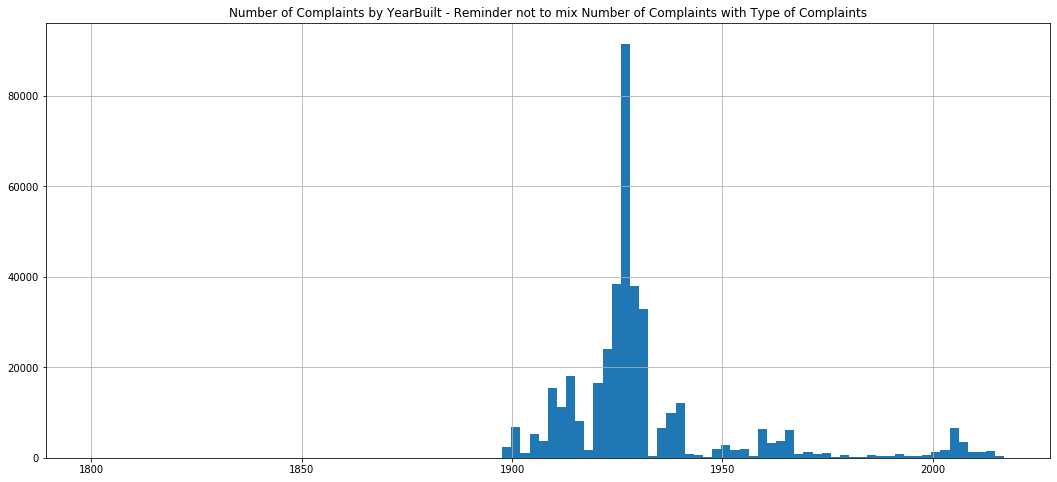

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

plt.title("Number of Complaints by YearBuilt - Reminder not to mix Number of Complaints with Type of Complaints")
mergerd_subset.YearBuilt[mergerd_subset.YearBuilt != 0].hist(bins=100, ax=ax)

## COMMENTS

- Note that many buildings in NY are from 1920-1940 period. This should not be confused with a relation with heat problems, there are simply more buildings from that area than others.
- To check a true relation, we will check the **proportion** of problems being heat related, instead of actual count


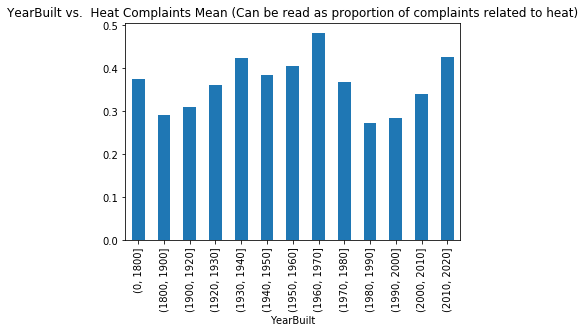

In [13]:
%matplotlib inline

title="YearBuilt vs.  Heat Complaints Mean (Can be read as proportion of complaints related to heat)"
mergerd_subset.groupby( pd.cut(mergerd_subset.YearBuilt, bins=[0,1800,1900,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020]) ).agg({"heat_related_count":['mean']}).plot(title=title, kind='bar',legend=False)

## COMMENTS

- No strong relation with YearBuilt and proportion of problems being Heat related

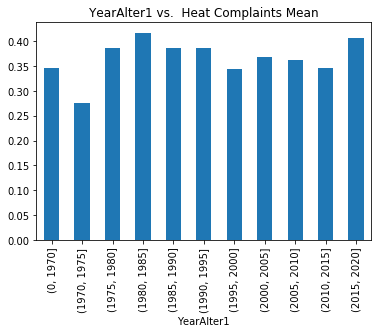

In [23]:
%matplotlib inline

title="YearAlter1 vs.  Heat Complaints Mean"
mergerd_subset.groupby( pd.cut(mergerd_subset.YearAlter1, bins=[0,1970]+ [1975 + d*5 for d in range(10)]) ).agg({"heat_related_count":['mean']}).plot(title=title, kind='bar',legend=False)

## COMMENTS

- No strong relation with YearAlter and proportion of problems being Heat related

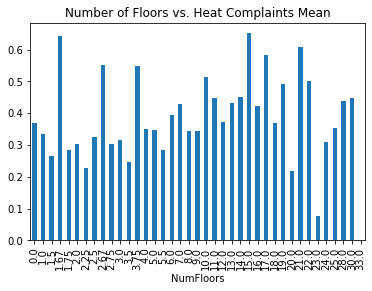

In [24]:
%matplotlib inline

title="Number of Floors vs. Heat Complaints Mean"
mergerd_subset.groupby( "NumFloors" ).agg({"heat_related_count":['mean']}).plot(kind='bar',legend=False, title=title)

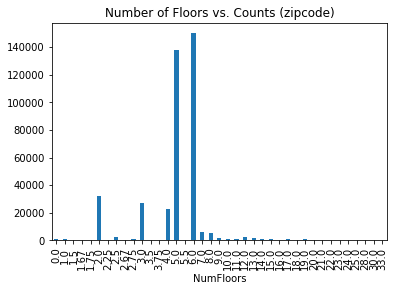

In [27]:
%matplotlib inline
"""
Note that dataset is EXTREMELY skewed - and not uniform distributed along number of floors
"""
title="Number of Floors vs. Counts (zipcode)"
mergerd_subset.groupby( "NumFloors" ).agg({"ZipCode":['count']}).plot(kind='bar',legend=False, title=title)

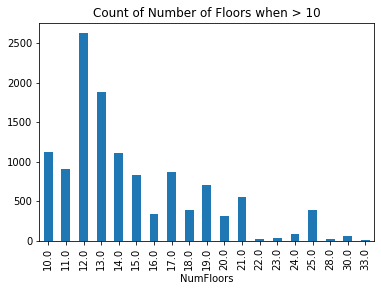

In [28]:
%matplotlib inline
"""
Note that dataset is EXTREMELY skewed - and not uniform distributed along number of floors
"""
title="Count of Number of Floors when > 10"
mergerd_subset[mergerd_subset.NumFloors >= 10].groupby( "NumFloors" ).agg({"ZipCode":['count']}).plot(kind='bar',legend=False, title=title)

## COMMENTS

- No strong relation with NumFloors and proportion of problems being Heat related
- Very few houses with high number of floors - relations are dangerous to generalize

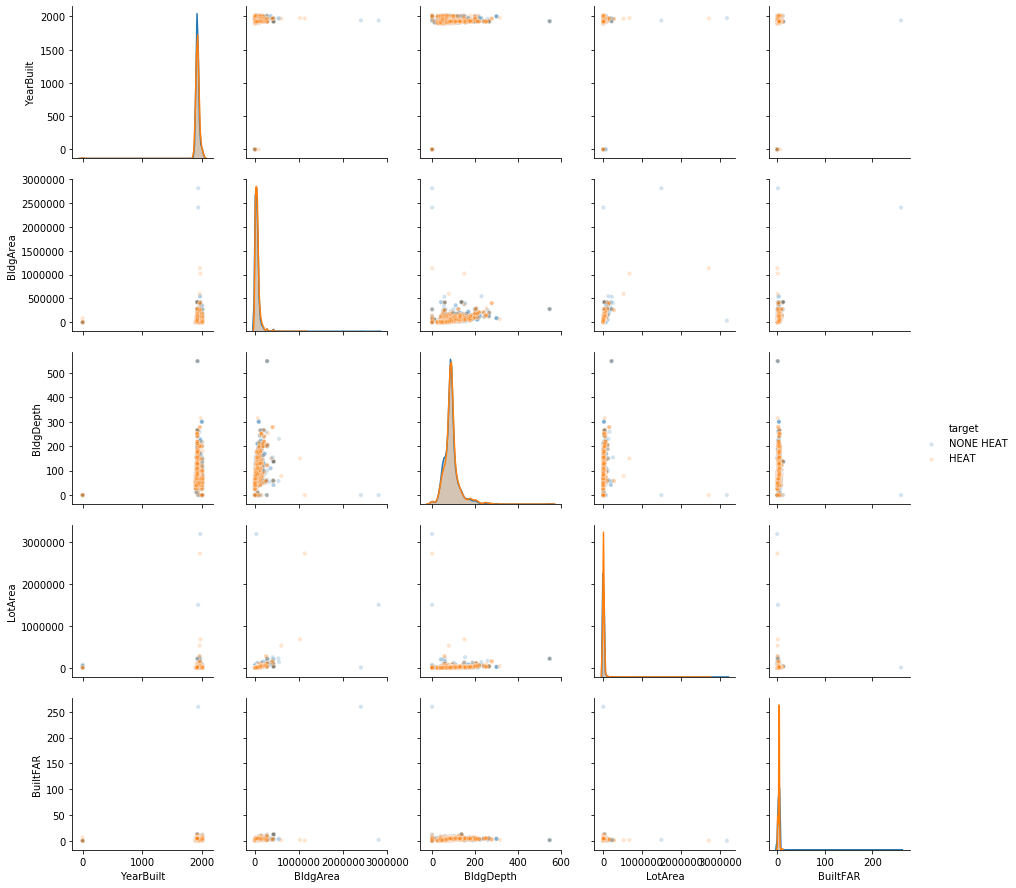

In [51]:
%matplotlib inline

import seaborn as sns

grid = sns.pairplot(mergerd_subset.sample(5000),
             x_vars=["YearBuilt", "BldgArea", "BldgDepth", "LotArea", "BuiltFAR"],
             y_vars=["YearBuilt", "BldgArea", "BldgDepth", "LotArea", "BuiltFAR"],
             hue = 'target',
            plot_kws={'alpha':0.2, 'size':.5}
            )

grid

## COMMENTS

Based on Scatter Plot

- BldgArea & BldgDepth seems to have true relation with problems being more heat related, lets investigate more!

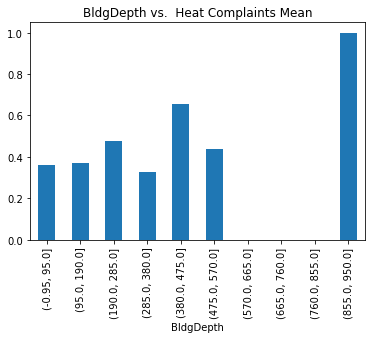

In [52]:
%matplotlib inline

title="BldgDepth vs.  Heat Complaints Mean"
cuts=10
mergerd_subset.groupby( pd.cut(mergerd_subset.BldgDepth, bins=cuts) ).agg({"heat_related_count":['mean']}).plot(title=title, kind='bar',legend=False)

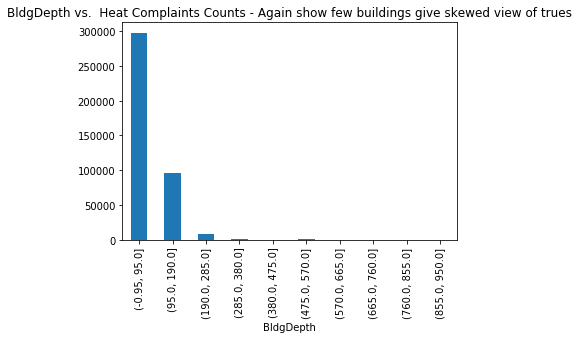

In [53]:
%matplotlib inline

title="BldgDepth vs.  Heat Complaints Counts - Again show few buildings give skewed view of trues"
cuts=10
mergerd_subset.groupby( pd.cut(mergerd_subset.BldgDepth, bins=cuts) ).agg({"heat_related_count":['count']}).plot(title=title, kind='bar',legend=False)

## COMMENTS

Indeed, BldgDepth being around 330~385 seems to be related to heat problems.
This could be due to certain type of building, as there are not many

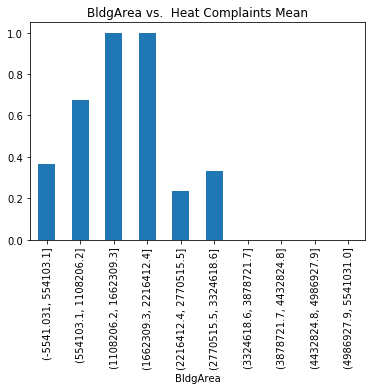

In [54]:
%matplotlib inline

title="BldgArea vs.  Heat Complaints Mean"
cuts=10
mergerd_subset.groupby( pd.cut(mergerd_subset.BldgArea, bins=cuts) ).agg({"heat_related_count":['mean']}).plot(title=title, kind='bar',legend=False)

## COMMENTS

Indeed, BldgArea being around 700.000 _ 1000.000 seems to be related to heat problems.
This could be due to certain type of building

In [33]:
cleaned_data = mergerd_subset.dropna() 

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold

x_train, x_test, y_train, y_test = train_test_split(cleaned_data[recommended_fields], cleaned_data["target"])

In [35]:
%%time

clf = RandomForestClassifier(n_estimators=20)
clf.fit(x_train, y_train)

CPU times: user 10.5 s, sys: 0 ns, total: 10.5 s
Wall time: 10.5 s


In [36]:
clf.classes_

array(['HEAT', 'NONE HEAT'], dtype=object)

In [37]:
from sklearn.metrics import accuracy_score, classification_report


In [38]:
y_pred = clf.predict(x_test)
y_preds_train = clf.predict(x_train)


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        HEAT       0.66      0.46      0.54     36722
   NONE HEAT       0.73      0.86      0.79     63712

    accuracy                           0.71    100434
   macro avg       0.69      0.66      0.67    100434
weighted avg       0.71      0.71      0.70    100434



In [40]:
print(classification_report(y_train, y_preds_train))

              precision    recall  f1-score   support

        HEAT       0.70      0.49      0.58    109296
   NONE HEAT       0.75      0.88      0.81    192004

    accuracy                           0.74    301300
   macro avg       0.72      0.68      0.69    301300
weighted avg       0.73      0.74      0.73    301300



## COMMENTS

- Model shows acceptable performance, without overfitting 

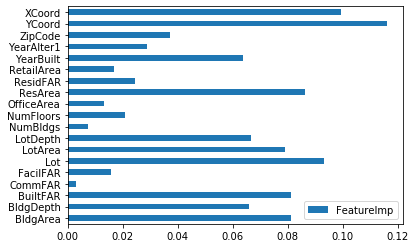

In [41]:
%matplotlib inline

pd.DataFrame(clf.feature_importances_, index=x_train.columns, columns=["FeatureImp"]).plot(kind="barh")

## COMMENTS

- Based on feature importance, location is the most contributing factor to being of class 'heat related problems'
- We will repeat and remove all location feature to check if we can extract building characteristics

## Repeat without location Characteritcs

In [42]:
BUILDING_CHARACTERISTICS = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR',
       'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1']

building_data = cleaned_data[BUILDING_CHARACTERISTICS]
building_data.head()

BldgArea  BldgDepth  BuiltFAR  CommFAR  FacilFAR  LotArea  LotDepth  \
0      4200       55.0      1.85      0.0       2.0     2268     75.44   
1      4200       55.0      1.85      0.0       2.0     2268     75.44   
2      4200       55.0      1.85      0.0       2.0     2268     75.44   
3      4200       55.0      1.85      0.0       2.0     2268     75.44   
4      4200       55.0      1.85      0.0       2.0     2268     75.44   

   NumBldgs  NumFloors  OfficeArea  ResArea  ResidFAR  RetailArea  YearBuilt  \
0         1        0.0           0     3300      1.25           0       2008   
1         1        0.0           0     3300      1.25           0       2008   
2         1        0.0           0     3300      1.25           0       2008   
3         1        0.0           0     3300      1.25           0       2008   
4         1        0.0           0     3300      1.25           0       2008   

   YearAlter1  
0           0  
1           0  
2           0  
3           0  
4           0

In [43]:
x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(building_data[BUILDING_CHARACTERISTICS], cleaned_data["target"])

In [44]:
clf_building = RandomForestClassifier(n_estimators=20)
clf_building.fit(x_train_b, y_train_b)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
y_pred_b = clf_building.predict(x_test_b)
y_preds_train_b = clf_building.predict(x_train_b)

In [46]:
print(classification_report(y_test_b, y_pred_b))

              precision    recall  f1-score   support

        HEAT       0.65      0.45      0.53     36526
   NONE HEAT       0.73      0.86      0.79     63908

    accuracy                           0.71    100434
   macro avg       0.69      0.66      0.66    100434
weighted avg       0.70      0.71      0.70    100434



In [47]:
print(classification_report(y_train_b, y_preds_train_b))

              precision    recall  f1-score   support

        HEAT       0.69      0.48      0.57    109492
   NONE HEAT       0.75      0.88      0.81    191808

    accuracy                           0.73    301300
   macro avg       0.72      0.68      0.69    301300
weighted avg       0.73      0.73      0.72    301300



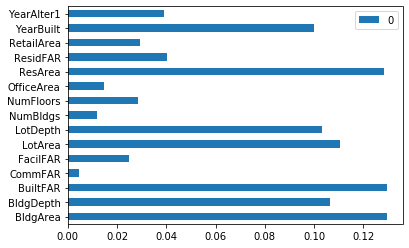

In [55]:
%matplotlib inline

pd.DataFrame(clf_building.feature_importances_, index=x_train_b.columns).plot(kind="barh")

## COMMENTS

- Simple Plots hint that Building Size/Area is related
- RandomForest Feature Importance - with location, shows location based features are most important to predict heat related problems
- RandomForest Feature Importance - without location shows BldgArea, and ResArea are more important to predict heat related problems

- My intuition is that a few large buildings with many heat complaints mint hint on a relation with building characteristics, but that the found relation won't generalize well for the majority of the data. If more time, I would create subgroups of data (building small, medium, large) and investigate all subgroups, and create models for each subgroups. This would certainly reveal new insights, unknown to this point.